### TODO:

- Fit NegBinom to data using MLE, and use MLE for R0 and k
- Set R0 to be mean of sample, and use MLE to find k
- Use method of moments to find R0 and k
- Do this for NegBinom, Poisson and Geometric distributions

- This:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fit.html
- seems to suggest that we can set it to MLE for one param with the other fixed, or in some very small neighbourhood. Investigate this.

This is an idea to use co-aggregation data to generate a Co-aggregation Distribution. We could use this to simulate contact tracing network datasets, which we can then use with the methods set out by Lloyd-Smith et al (2005).

---

Co-aggregation is the phenomenon where larval and nymphal ticks co-feed on the same relatively small number of vertebrate hosts; the 80:20 rule is frequently found to be a good description of tick aggregation.

Co-aggregation can be thought of as a bipartite graph. The work by Johnstone-Robertson and others showed that if we treat each vertebrate host as a node, then the degree $ k_{in} $ is the number of nymphs and $ k_{out} $ is the number of larvae for any one node (vertebrate). That research is the inspiration for the following idea.

A single vertebrate host might have this co-aggregation network, with $k_{in}$ nymphs and $k_{out}$ larvae:

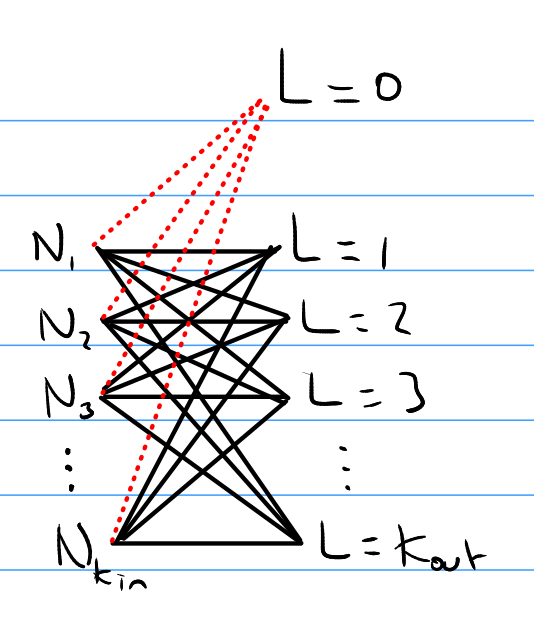

We can ask: what is the expected number of larvae that an individual nymph will co-aggregate with? We include the cases where a nymph doesn't co-aggregate with any larvae, which is known as a "wasted bite". We do not consider the situation where larvae aggregate without nymphs.

Then for each vertebrate, or node in the network, and for each nymph on that vertebrate, record the $ k_{out} $ as the number of larvae that a single nymph co-aggregates with. Let these values form a "Co-aggregation Distribution". We could either:

- Fit an appropriate distribution to the data and draw variables from it randomly.
- Take the Co-aggregation Distribution as-is and draw from it uniform-randomly.

For simplicity, for now, use the second option.

---

This is a process for generating an offspring distribution.

Definitions:
- Let $ c $ be the contact rate, or probability that co-aggregation occurs close enough for a nymph to transmit the pathogen to a larva.
- Let $ v $ be the probability of successfully transmitting the pathogen from nymph to larvae. This accounts for individual transmission competence.
- Let $ \sigma $ be the probability that an infected larvae survives to become a nymph.
- Let $ \alpha = \sigma v c $ be the overall probability that a larvae becomes an infectious nymph. In other words, a larvae that coaggregates with a nymph becomes an offspring.

Then we can simulate disease outbreaks with the below stochastic process:

- Start with one infected nymph and uniform randomly draw $ L $ from the Co-aggregation Distribution. $ L $ is a random variable of the number of larvae that a single nymph co-aggregates with. This would be $ k_{out} $, in the notation created by Johnstone-Robertson and others in 2020.
- If $ L = 0 $ then this nymph has no offspring.
- For each larvae in $ [1:L] $:
    - The larvae becomes an offspring (infectious nymph) with probability of $ \alpha $.
- Repeat for all infected nymphs.

Then with this stochastic process, the expected number of larvae to be infected per infected nymph is $ E(L) = \sum \left( \alpha L \right) = \alpha \sum L $. Then this Co-aggregation Distribution, once scaled by $ \alpha $, is an offspring distribution. Then with the Co-aggregation Distribution, and with the user-defined $ \alpha = \sigma v c $, we can avoid actually running a stochastic process and just use the scaled Co-aggregation Distribution to 

Alternatively, you could use the stochastic process to generate simulated outbreaks and then use those to fit distributions via MLE, as Lloyd-Smith and others have done.

Since the definition of $ R_0 $ is the number of new infection per existing infection, then $ R_0 = E(L) $. Then all that remains is to fit the dispersion parameter, $ k $, as Lloyd-Smith et al did in 2005.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [2]:
df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

df_SA_ricinus_trianguliceps = df[df["Species"] == "SA"]

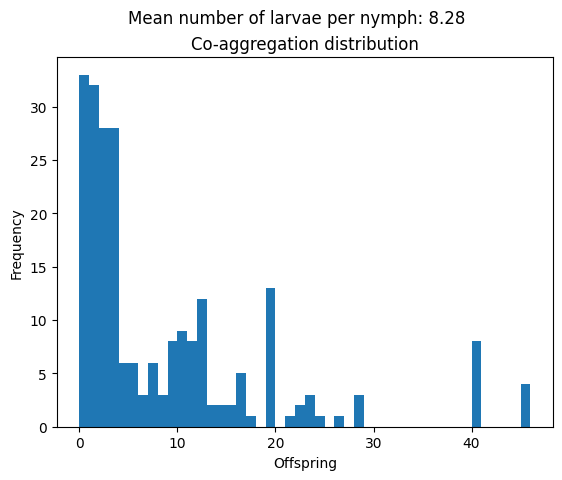

In [35]:
coaggregation_distribution = np.array([], dtype=np.int64)

for i, row in df_SA_ricinus_trianguliceps.iterrows():
    nymph_count = row["Nymphs"]
    larvae_count = row["Larvae"]
    larvae_coaggregating = np.repeat(larvae_count, nymph_count)
    coaggregation_distribution = np.append(coaggregation_distribution, larvae_coaggregating)

plt.hist(coaggregation_distribution, bins=max(offspring_distribution))
plt.suptitle("Mean number of larvae per nymph: {0:.2f}".format(np.mean(coaggregation_distribution)))
plt.title("Co-aggregation distribution")
plt.xlabel("Offspring")
plt.ylabel("Frequency")
plt.show()


Note: Attempts were made to use Python packages `distfit` and `fitter` for batch-processing MLE. Disfit only fits binom, and fitter failed to fit anything. Proceed with fitting using Scipy, and do our own AIC, BIC and other goodness-of-fit checks.

In [24]:
from scipy import stats

distributions=[stats.nbinom]

for dist in distributions:
    n,p = stats.fit(dist, offspring_distribution, bounds=[(0,100),(0,100)])

print(n, p)


TypeError: cannot unpack non-iterable FitResult object

In [84]:
import numpy as np
import pandas as pd

simulationCount = 10000
n = 3 #nymphal burden
l = 6 #larval burden

O = np.empty((0, n)) # offspring

for i in range(simulationCount):

    O_i = [] # Offspring for one vertebrate
    
    s = l # susceptible larvae
    for n_i in range(n):
        if n_i == n-1:
            O_i.append(s)
        else:
            a_i = np.random.randint(low=0, high=s+1)
            s = s - a_i
            O_i.append(a_i)
    
    O = np.vstack([O, O_i])

In [85]:
# The first is independent of the next two, so an infinite number of random draws will give the expected value, or the AM

for n_i in range(n):
    print(np.mean(O[:,n_i]))

3.0329
1.4994
1.4677


In [76]:
import numpy as np
import pandas as pd

simulationCount = 10000
n = 3 #nymphal burden
l = 6 #larval burden

O = np.empty((0, n)) # offspring

for i in range(simulationCount):

    O_i = [] # Offspring for one vertebrate
    
    s = l # susceptible larvae
    for n_i in range(n):
        a_i = np.random.randint(low=0, high=s+1)
        s = s - a_i
        O_i.append(a_i)
    
    O = np.vstack([O, O_i])

In [77]:
for n_i in range(n):
    print(np.mean(O[:,n_i]))

3.014
1.491
0.7474


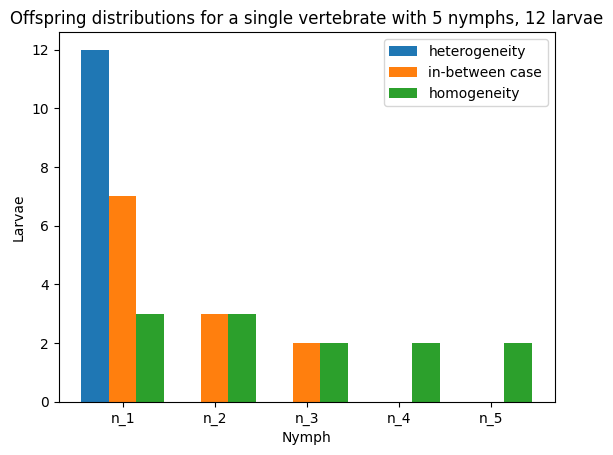

In [103]:
### Example of offspring distributions on a single vertebrate

import matplotlib.pyplot as plt

l = 12
n = 5

import numpy as np
import matplotlib.pyplot as plt

cats = ['n_1', 'n_2', 'n_3', 'n_4', 'n_5'] # categories
heterogeneity = [12, 0, 0, 0, 0]
homogeneity = [3, 3, 2, 2, 2]
between_case = [7, 3, 2, 0, 0]

# Bar width and x locations
w, x = 0.3, np.arange(len(cats))

fig, ax = plt.subplots()
ax.bar(x - w, heterogeneity, width=w, label='heterogeneity')
ax.bar(x , between_case, width=w, label='in-between case')
ax.bar(x + w, homogeneity, width=w, label='homogeneity')

ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_ylabel('Larvae')
ax.set_xlabel('Nymph')
ax.set_title('Offspring distributions for a single vertebrate with 5 nymphs, 12 larvae')
ax.legend()

plt.show()


TypeError: can't multiply sequence by non-int of type 'float'